# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [37]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [38]:
path = '/content/drive/MyDrive/data/gameofthrones.txt'

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import re

In [41]:
class Vocab:
    def __init__(self, data):
        self.data = self.preprocess(data)

        self.char2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2char = {}

        for char in self.data:
            self.char2idx[char] = len(self.char2idx) if char not in self.char2idx else self.char2idx[char]

        self.idx2char = dict(zip(self.char2idx.values(), self.char2idx.keys()))

    def tokenize(self, sequence):
        sequence = self.preprocess(sequence)

        return [self.char2idx[char] for char in sequence]
    
    def preprocess(self, sequence):
        sequence = sequence.lower()
        sequence = re.sub(r'\n', ' ', sequence)

        regex = re.compile('[^a-zA-Z]')
        sequence = regex.sub(' ', sequence)

        sequence = re.sub(' {2,}', ' ', sequence)
        sequence = sequence.strip()

        return sequence

    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [69]:
class TextDataset():
    def __init__(self, data_path, length=150):
        data = open(data_path).read()
        self.length = length
        # обучите вокаб
        self.vocab = Vocab(data)

        # разделите данные на отдельные сэмплы для обучения
        # (просто список из сырых строк)
        self.data = []

        n = len(self.vocab.data) // length
        for i in range(n):
            self.data.append(self.vocab.data[i * length : (i + 1) * length])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        txt = self.data[idx]
        sample = self.vocab.tokenize(txt[:-1])
        target = self.vocab.tokenize(txt[1:])
        while len(sample) < self.length:
            sample.append(self.vocab.char2idx['<PAD>'])
        while len(target) < self.length:
            target.append(self.vocab.char2idx['<PAD>'])
        sample = torch.LongTensor(sample)
        target = torch.LongTensor(target)
        
        return sample, target

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

Разобьём на обучение и валидацию:

In [70]:
dataset = TextDataset(path)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [140]:
class LM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        decoded = self.decoder(output.reshape(output.size(0)*output.size(1), output.size(2)))
        output = decoded.view(output.size(0), output.size(1), decoded.size(1))

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

## Обучение

In [165]:
epochs = 5
lr = 1e-3 
batch_size = 64

In [166]:
train = DataLoader(train_set, batch_size=batch_size)
test = DataLoader(test_set, batch_size=batch_size)

In [167]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LM(
    input_size=len(dataset.vocab),
    hidden_size=128,
    embedding_dim=128,
    output_size=len(dataset.vocab)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [168]:
from tqdm import tqdm

In [169]:
history = []
history_val = []

for e in tqdm(range(epochs)):
    for x, y in train:
        model.train()
        optimizer.zero_grad()
        
        # 0. Распакуйте данные на нужное устройство
        x = x.to(device)
        y = y.to(device)

        # 1. Инициилизируйте hidden
        hidden = model.init_hidden(len(x))
        
        # 2. Прогоните данные через модель, получите предсказания на каждом токене
        output, hidden = model(x, hidden)
        
        # 3. Посчитайте лосс (maxlen независимых классификаций) и сделайте backward()
        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))
        loss.backward()

        # 4. Клипните градиенты -- у RNN-ок с этим часто бывают проблемы
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)

        # 5. Залоггируйте лосс куда-нибудь
        history.append(loss.item())

        optimizer.step()

    for x, y in test:
        model.eval()
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        hidden = model.init_hidden(len(x))
        output, hidden = model(x, hidden)
        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)

        history_val.append(loss.item())

        optimizer.step()
        

100%|██████████| 5/5 [09:21<00:00, 112.40s/it]


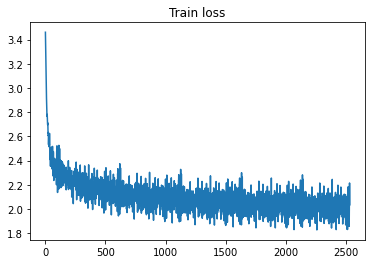

In [172]:
plt.title('Train loss')
plt.plot(history)
plt.show()

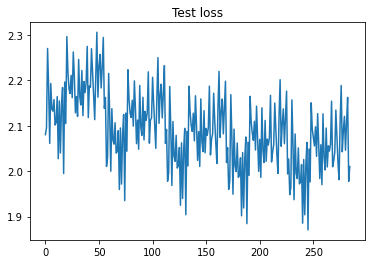

In [173]:
plt.title('Test loss')
plt.plot(history_val)
plt.show()

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [170]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [378]:
def spellcheck(sequence):
    model.eval()
    
    # векторизуйте sequence; паддинги делать не нужно
    sequence_encoded = torch.LongTensor(dataset.vocab.tokenize(sequence)).reshape(1, -1).to(device)
    # прогоните модель и посчитайте лосс, но не усредняйте
    # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
    hidden = model.init_hidden(1)
    result, _ = model(sequence_encoded, hidden)
    
    print_colored(sequence, (result * 200).reshape(-1).cpu().detach())

In [379]:
sequences = ['Thes sentance has many mistekas', 
             'There is extra lettter.', 
             'This sentence is correct.']

for sequence in sequences:
    spellcheck(sequence)

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [328]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
        
    hidden = model.init_hidden(1)
    input = torch.LongTensor(dataset.vocab.tokenize(seed)).reshape(1, -1).to(device)    
    soft = nn.Softmax()

    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = soft(output.squeeze()).div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]
        
        continuation += dataset.vocab.idx2char[token.item()]
        input = torch.LongTensor(dataset.vocab.tokenize(seed + continuation)).reshape(1, -1).to(device)

    return continuation

In [329]:
beginnings = ['A bear walked through the forest', 
              'An Englishman, an American and a Russian met. Englishman says:',
              'So, one day the pitching decided to make repairs',
              'Lieutenant Rzhevsky was',
              'The Buddha is walking along the road with his disciples',
              'Muller: Stirlitz, where were you in 1938?',
              'The Americans are sending us a spy under the guise of a student',
              'The train is approaching Dolgopa:']

for beginning in beginnings:
    print(f'{beginning}... {sample(10, beginning)}')
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


A bear walked through the forest... uf<START>dcfczvn

An Englishman, an American and a Russian met. Englishman says:... cfkueh ben

So, one day the pitching decided to make repairs... uw tbv ztx

Lieutenant Rzhevsky was... mvw<PAD>pqcw i

The Buddha is walking along the road with his disciples... c<END><UNK>kxm<START>ixg

Muller: Stirlitz, where were you in 1938?... <PAD>lthj<PAD>e<UNK>pf

The Americans are sending us a spy under the guise of a student... hrzddgdqt 

The train is approaching Dolgopa:... edbxlxmqwx

